In [1]:
# q_learning_single_robot.py - starter script (single-robot Q-learning)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random

In [2]:
GRID_SIZE = 10
grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
static_obstacles = [(2, 3), (5, 5), (3, 7), (6, 2), (7,7)]
for (x, y) in static_obstacles:
    grid[x, y] = 1
start = (0, 0)
goal = (9, 9)
ACTIONS = [(-1,0),(1,0),(0,-1),(0,1)]

In [3]:
def in_bounds(pos):
    x,y = pos
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE

def step(state, action):
    x, y = state
    dx, dy = ACTIONS[action]
    nx, ny = x+dx, y+dy
    next_pos = (nx, ny)
    if not in_bounds(next_pos) or grid[nx, ny] == 1:
        return state, -10, False
    if next_pos == goal:
        return next_pos, 10, True
    return next_pos, -1, False

In [4]:
def draw_grid(grid, robot_pos=None, path=None, show=True, pause=0.25):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(grid)
    ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1))
    ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, linewidth=0.5)
    for (x,y) in static_obstacles:
        ax.scatter(y, x, s=180, marker='s')
    gx, gy = goal
    ax.text(gy, gx, "G", va='center', ha='center', fontsize=10)
    if path is not None and len(path) > 0:
        ys = [p[1] for p in path]
        xs = [p[0] for p in path]
        ax.plot(ys, xs, linewidth=2)
    if robot_pos is not None:
        rx, ry = robot_pos
        ax.scatter(ry, rx, s=220, marker='o')
    if show:
        plt.show(block=False)
        plt.pause(pause)
        plt.close(fig)
    return fig, ax

In [5]:
# Q-learning parameters
q_table = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)), dtype=float)
alpha = 0.1
gamma = 0.9
epsilon = 0.3
min_epsilon = 0.05
decay = 0.995
episodes = 600
max_steps = 100

In [6]:
for ep in range(episodes):
    state = start
    for step_i in range(max_steps):
        x,y = state
        if random.random() < epsilon:
            action = random.randint(0, len(ACTIONS)-1)
        else:
            action = int(np.argmax(q_table[x,y]))
        next_state, reward, done = step(state, action)
        nx, ny = next_state
        old = q_table[x, y, action]
        future = 0 if done else np.max(q_table[nx, ny])
        q_table[x, y, action] = old + alpha * (reward + gamma * future - old)
        state = next_state
        if done:
            break
    epsilon = max(min_epsilon, epsilon * decay)

In [7]:
# test greedy path
state = start
path = [state]
for _ in range(200):
    x,y = state
    action = int(np.argmax(q_table[x,y]))
    next_state, reward, done = step(state, action)
    if next_state == state and reward < 0:
        break
    path.append(next_state)
    state = next_state
    if done:
        break

print("Test path length:", len(path), "Reached goal:", path[-1] == goal)

Test path length: 19 Reached goal: True


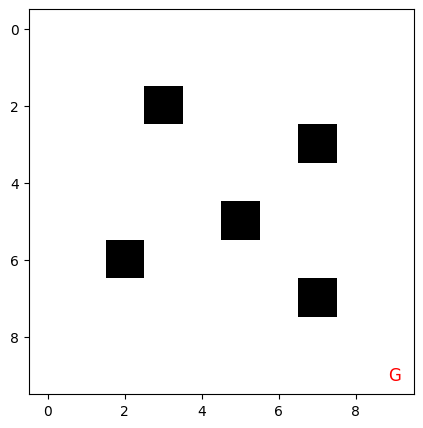

In [8]:
# ---------------- Smooth Animation ----------------
def animate_path(grid, path, obstacles, goal, interval=300):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(grid, cmap="Greys")

    # Draw obstacles
    for (x, y) in obstacles:
        ax.scatter(y, x, s=180, marker="s", color="black")

    # Draw goal
    gx, gy = goal
    ax.text(gy, gx, "G", va="center", ha="center", fontsize=12, color="red")

    # Robot marker and path line
    robot_dot, = ax.plot([], [], "ro", markersize=12)
    path_line, = ax.plot([], [], "b-", linewidth=2)

    def init():
        robot_dot.set_data([], [])
        path_line.set_data([], [])
        return robot_dot, path_line

    def update(frame):
        xs = [p[0] for p in path[:frame+1]]
        ys = [p[1] for p in path[:frame+1]]
        robot_dot.set_data(ys[-1], xs[-1])   # robot position
        path_line.set_data(ys, xs)           # path so far
        return robot_dot, path_line

    ani = FuncAnimation(fig, update, frames=len(path),
                        init_func=init, blit=True,
                        interval=interval, repeat=False)
    plt.show()

# Run the animation
animate_path(grid, path, static_obstacles, goal)